/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


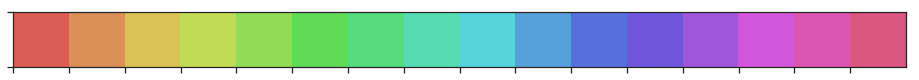

In [2]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.gridspec as gridspec

rc('text', usetex=False)
matplotlib.rcParams['svg.fonttype'] = 'none'
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

sys.path.insert(0, '/home/bay001/projects/codebase/rbp-maps/maps/')
from density import Map
from density import ReadDensity
from density import normalization_functions
from plotter import Plotter
from density import LineObject as dline
from peak import LineObject as pline
# from peak import PeakPlotter

sns.palplot(sns.color_palette("hls", 16))
colors = sns.color_palette("hls", 16)
density_colors = [colors[0], colors[9], 'black']
peak_colors = [colors[1], colors[8], 'black']

FONTSIZE=8

In [3]:
density_dir = '/projects/ps-yeolab3/bay001/maps/current/se_zscore/'
peak_dir = '/projects/ps-yeolab3/bay001/maps/current/se_peak_hist'

density_included = os.path.join(
    density_dir, '204_01_RBFOX2.merged.r2.1.RBFOX2-BGHLV26-HepG2-included-upon-knockdown.normed_matrix.txt'
)
density_excluded = os.path.join(
    density_dir, '204_01_RBFOX2.merged.r2.1.RBFOX2-BGHLV26-HepG2-excluded-upon-knockdown.normed_matrix.txt'
)
density_native_cass = os.path.join(
    density_dir, '204_01_RBFOX2.merged.r2.1.HepG2_native_cassette_exons.normed_matrix.txt'
)

excl_peak_pvalue = '/projects/ps-yeolab3/bay001/maps/current/se_peak/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.Excluded_upon_knockdown_(138_events).pvalue'
incl_peak_pvalue = '/projects/ps-yeolab3/bay001/maps/current/se_peak/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.Included_upon_knockdown_(113_events).pvalue'

excl_read_pvalue = '/projects/ps-yeolab3/bay001/maps/current/se/204_01_RBFOX2.merged.r2.1.RBFOX2-BGHLV26-HepG2-excluded-upon-knockdown.pvalues.txt'
incl_read_pvalue = '/projects/ps-yeolab3/bay001/maps/current/se/204_01_RBFOX2.merged.r2.1.RBFOX2-BGHLV26-HepG2-included-upon-knockdown.pvalues.txt'

output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/204_01_peak_vs_density_with_pvalue_heatmaps_as_hist.svg'

In [4]:
def split(lst, n):
    """
    Splits list (lst) into n equal parts.

    Parameters
    ----------
    lst : list
    n : int

    Returns
    -------
    newlist : list
        a list of equally portioned n sublists
    """
    newlist = []
    division = len(lst) / float(n)
    for i in xrange(n):
        newlist.append(
            lst[int(round(division * i)):int(round(division * (i + 1)))])
    return newlist

def plot_heatmap(lst, axs, colors, remove_lines):
    num_regions = 4
    pvalues = split(lst, num_regions)
    for i in range(0, num_regions):
        axs[i].pcolor(
            [pvalues[i]], 
            cmap=colors
        )
        axs[i].set_yticklabels([''])
        axs[i].set_yticks([''])
        axs[i].xaxis.set_visible(False)
        axs[i].set_ylim(0, 1)
        if remove_lines:
            sns.despine(ax=axs[i], top=True, left=True, right=True, bottom=True)
        else:
            sns.despine(ax=axs[i], top=True, left=True, right=True, bottom=False)
            
def mask(l):
    """
    Return 0 if not significant (anything less than 1.3ish)
    """
    return 0 if l < -np.log10(0.05) else 1

In [5]:
p=3
fc=0

peak_dir = '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_CLIPperv2_20161120/'
peak_annotation_dir = '/projects/ps-yeolab3/bay001/maps/current_annotations/as_miso_renamed'

out_incl_hist = '/projects/ps-yeolab3/bay001/maps/test/incl.txt'# temp file
out_excl_hist = '/projects/ps-yeolab3/bay001/maps/test/excl.txt'# temp file
out_excl_hist = '/projects/ps-yeolab3/bay001/maps/test/bg.txt'# temp file

peak_bed = os.path.join(peak_dir, '204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed')
peak_included_annotation = os.path.join(peak_annotation_dir, 'RBFOX2-BGHLV26-HepG2-included-upon-knockdown')
peak_excluded_annotation = os.path.join(peak_annotation_dir, 'RBFOX2-BGHLV26-HepG2-excluded-upon-knockdown')
peak_bg_annotation = os.path.join(peak_annotation_dir, 'HepG2-native-cassette-exons.miso')

peak_incl = pline.LineObject(
    infile=peak_bed,
    out_hist=out_incl_hist,
    annotation=peak_included_annotation,
    l10p_cutoff=p,
    l2fc_cutoff=fc,
    hashing_val=100000,
    event_type='se',
    exon_overhang=50,
    intron_overhang=300,
    color=peak_colors[0],
    min_event_threshold=100,
    normalize=False
)

peak_excl = pline.LineObject(
    infile=peak_bed,
    out_hist=out_excl_hist,
    annotation=peak_excluded_annotation,
    l10p_cutoff=p,
    l2fc_cutoff=fc,
    hashing_val=100000,
    event_type='se',
    exon_overhang=50,
    intron_overhang=300,
    color=peak_colors[1],
    min_event_threshold=100,
    normalize=False
)

In [6]:
density_incl = dline.LineObject(
    event_matrix=pd.read_table(density_included, sep=',', index_col=0),
    annotation='Included upon knockdown',
    conf=0.95,
    color=density_colors[0], # blueish
    min_event_threshold=100
)
density_excl = dline.LineObject(
    event_matrix=pd.read_table(density_excluded, sep=',', index_col=0),
    annotation='Excluded upon knockdown',
    conf=0.95,
    color=density_colors[1], # reddish
    min_event_threshold=100
)

((113, 1400), 'Included upon knockdown (113 events)')
((138, 1400), 'Excluded upon knockdown (138 events)')


/home/bay001/anaconda2/envs/brian/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


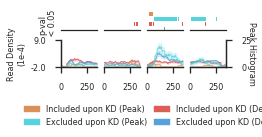

In [7]:
mag = 1
fig = plt.figure(figsize=(4*mag, 1*mag))
full_grid = gridspec.GridSpec(6, 4, height_ratios=[1, 1, 1, 1, 2, 8], )

excl_read_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[3, 1:4])
incl_read_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[2, 1:4])
excl_peak_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[1, 1:4])
incl_peak_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[0, 1:4])
spacer_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[4, 1:4])

map_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[5, 1:4])

read_map_regions = []
peak_map_regions = []

excl_read_heatmap_regions = []
incl_read_heatmap_regions = []
excl_peak_heatmap_regions = []
incl_peak_heatmap_regions = []

for i in range(4):
    read_map_regions.append(plt.subplot(map_row[i:i+1]))
    peak_map_regions.append(read_map_regions[i].twinx())
    excl_read_heatmap_regions.append(plt.subplot(excl_read_heatmap_row[i:i+1]))
    incl_read_heatmap_regions.append(plt.subplot(incl_read_heatmap_row[i:i+1]))
    excl_peak_heatmap_regions.append(plt.subplot(excl_peak_heatmap_row[i:i+1]))
    incl_peak_heatmap_regions.append(plt.subplot(incl_peak_heatmap_row[i:i+1]))

density_plotter = Plotter._Plotter(lines=[density_incl, density_excl], num_regions=4)
read_map_regions = density_plotter.plot(read_map_regions, None)

read_plotter = Plotter._Plotter(lines=[peak_incl, peak_excl], num_regions=4)
peak_map_regions = read_plotter.plot(peak_map_regions, None)
# RDPlotter.plot_se([density_incl, density_excl], read_map_regions, density_colors) # density_bg
# peak_map_regions = Plotter.plot_se([peak_incl, peak_excl], 'tmp.out') # peak_bg

incl_read_heatmap_regions[0].set_ylabel('p-val\n < 0.05', size=FONTSIZE)

read_map_regions[0].set_ylabel("Read Density\n(1e-4)", size=FONTSIZE)
read_map_regions[3].yaxis.set_visible(False)

peak_map_regions[0].yaxis.set_visible(False)
peak_map_regions[3].yaxis.set_visible(True)
peak_map_regions[3].set_ylabel("Peak Histogram", rotation=270, size=FONTSIZE)
peak_map_regions[3].yaxis.tick_right()

read_ymin = -0.0002
read_ymax = 0.0009
peak_ymin = 0
peak_ymax = 25

for ax in read_map_regions:
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_ylim(read_ymin, read_ymax)
    
for ax in peak_map_regions:
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_ylim(peak_ymin, peak_ymax)

read_map_regions[0].yaxis.set_ticks([read_ymin, read_ymax])
read_map_regions[0].yaxis.set_ticklabels([read_ymin*10000, read_ymax*10000])
peak_map_regions[3].yaxis.set_ticks([peak_ymin, peak_ymax])
peak_map_regions[3].yaxis.set_ticklabels([peak_ymin, peak_ymax])

sns.despine(ax=read_map_regions[0], top=True, left=False, right=True)
sns.despine(ax=peak_map_regions[3], top=True, left=True, right=False)

# create lists of things to make parsing easier
pvalue_files = [incl_peak_pvalue, excl_peak_pvalue, incl_read_pvalue, excl_read_pvalue]

heatmap_regions = [
    incl_peak_heatmap_regions,
    excl_peak_heatmap_regions,
    incl_read_heatmap_regions,
    excl_read_heatmap_regions
]

# need to create cmaps based on each peak/read color
read_excl_cmap = matplotlib.colors.ListedColormap(['white', density_colors[1]], name='from_list', N=None)
read_incl_cmap = matplotlib.colors.ListedColormap(['white', density_colors[0]], name='from_list', N=None)
peak_excl_cmap = matplotlib.colors.ListedColormap(['white', peak_colors[1]], name='from_list', N=None)
peak_incl_cmap = matplotlib.colors.ListedColormap(['white', peak_colors[0]], name='from_list', N=None)

# despine stuff
for region in read_map_regions[1:3]:
    sns.despine(ax=region, top=True, left=True, right=True, bottom=False)
for region in peak_map_regions[1:3]:
    sns.despine(ax=region, top=True, left=True, right=True, bottom=False)
sns.despine(ax=peak_map_regions[0], top=True, left=False, right=True, bottom=False)
sns.despine(ax=read_map_regions[0], top=True, left=False, right=True, bottom=False)
sns.despine(ax=read_map_regions[3], top=True, left=True, right=False, bottom=False)
sns.despine(ax=peak_map_regions[3], top=True, left=True, right=False, bottom=False)


    
    
colors = [
    peak_incl_cmap, peak_excl_cmap, read_incl_cmap, read_excl_cmap
]

# plot the heatmaps
for i in range(0, len(pvalue_files)):
    lst = []
    lst = open(pvalue_files[i], 'r').readlines()
    lst = [float(l.rstrip().split('\t')[1]) for l in lst]
    # if i >= 2: # the read density pvalues are just pvalues, so let's plot the -log10 (fix later)
    #     lst = [p for p in lst] # [-np.log10(p) for p in lst]
    # hide anything that isn't significant.
    lst = [mask(l) for l in lst]
    # 
    remove_lines = True if i !=3 else False
    
    plot_heatmap(lst, heatmap_regions[i], colors[i], remove_lines)
    

incl_peak_patch = mpatches.Patch(color=peak_colors[0], label='Included upon KD (Peak)')
excl_peak_patch = mpatches.Patch(color=peak_colors[1], label='Excluded upon KD (Peak)')
incl_density_patch = mpatches.Patch(color=density_colors[0], label='Included upon KD (Density)')
excl_density_patch = mpatches.Patch(color=density_colors[1], label='Excluded upon KD (Density)')

leg = read_map_regions[0].legend(
    bbox_to_anchor=(2.5, -1.3), loc=1, mode="expand",
    handles=[incl_density_patch, excl_density_patch, incl_peak_patch, excl_peak_patch],
    borderaxespad=0., ncol=2, fontsize=FONTSIZE
)

# fig.savefig(output_file)

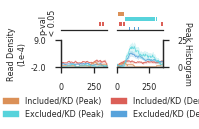

In [8]:
mag = 1
fig = plt.figure(figsize=(4*mag, 1*mag))
full_grid = gridspec.GridSpec(6, 2, height_ratios=[1, 1, 1, 1, 2, 8], )

excl_read_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=full_grid[3, 1:3])
incl_read_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=full_grid[2, 1:3])
excl_peak_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=full_grid[1, 1:3])
incl_peak_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=full_grid[0, 1:3])
spacer_row = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=full_grid[4, 1:3])

map_row = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=full_grid[5, 1:3])

read_map_regions = [plt.subplot()]*4
peak_map_regions = [plt.subplot()]*4

excl_read_heatmap_regions = [plt.subplot()]*4
incl_read_heatmap_regions = [plt.subplot()]*4
excl_peak_heatmap_regions = [plt.subplot()]*4
incl_peak_heatmap_regions = [plt.subplot()]*4

for i in range(1,3):
    read_map_regions[i] = (plt.subplot(map_row[i-1:i]))
    peak_map_regions[i] = (read_map_regions[i].twinx())
    excl_read_heatmap_regions[i] = (plt.subplot(excl_read_heatmap_row[i-1:i]))
    incl_read_heatmap_regions[i] = (plt.subplot(incl_read_heatmap_row[i-1:i]))
    excl_peak_heatmap_regions[i] = (plt.subplot(excl_peak_heatmap_row[i-1:i]))
    incl_peak_heatmap_regions[i] = (plt.subplot(incl_peak_heatmap_row[i-1:i]))

density_plotter = Plotter._Plotter(lines=[density_incl, density_excl], num_regions=4)
read_map_regions = density_plotter.plot(read_map_regions, None)

read_plotter = Plotter._Plotter(lines=[peak_incl, peak_excl], num_regions=4)
peak_map_regions = read_plotter.plot(peak_map_regions, None)
# RDPlotter.plot_se([density_incl, density_excl], read_map_regions, density_colors) # density_bg
# peak_map_regions = Plotter.plot_se([peak_incl, peak_excl], 'tmp.out') # peak_bg

incl_read_heatmap_regions[1].set_ylabel('p-val\n < 0.05', size=FONTSIZE)

read_map_regions[1].set_ylabel("Read Density\n(1e-4)", size=FONTSIZE)
read_map_regions[1].yaxis.set_visible(True)
read_map_regions[2].yaxis.set_visible(False)

peak_map_regions[1].yaxis.set_visible(False)
peak_map_regions[2].yaxis.set_visible(True)
peak_map_regions[2].set_ylabel("Peak Histogram", rotation=270, size=FONTSIZE)
peak_map_regions[2].yaxis.tick_right()

read_ymin = -0.0002
read_ymax = 0.0009
peak_ymin = 0
peak_ymax = 25

for ax in read_map_regions:
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_ylim(read_ymin, read_ymax)
    
for ax in peak_map_regions:
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_ylim(peak_ymin, peak_ymax)

read_map_regions[1].yaxis.set_ticks([read_ymin, read_ymax])
read_map_regions[1].yaxis.set_ticklabels([read_ymin*10000, read_ymax*10000])

peak_map_regions[2].yaxis.set_ticks([peak_ymin, peak_ymax])
peak_map_regions[2].yaxis.set_ticklabels([peak_ymin, peak_ymax])

sns.despine(ax=read_map_regions[1], top=True, left=False, right=True)
sns.despine(ax=peak_map_regions[2], top=True, left=True, right=False)

# create lists of things to make parsing easier
pvalue_files = [incl_peak_pvalue, excl_peak_pvalue, incl_read_pvalue, excl_read_pvalue]

heatmap_regions = [
    incl_peak_heatmap_regions,
    excl_peak_heatmap_regions,
    incl_read_heatmap_regions,
    excl_read_heatmap_regions
]

# need to create cmaps based on each peak/read color
read_excl_cmap = matplotlib.colors.ListedColormap(['white', density_colors[1]], name='from_list', N=None)
read_incl_cmap = matplotlib.colors.ListedColormap(['white', density_colors[0]], name='from_list', N=None)
peak_excl_cmap = matplotlib.colors.ListedColormap(['white', peak_colors[1]], name='from_list', N=None)
peak_incl_cmap = matplotlib.colors.ListedColormap(['white', peak_colors[0]], name='from_list', N=None)

# despine stuff
# for region in read_map_regions[1:3]:
#     sns.despine(ax=region, top=True, left=True, right=True, bottom=False)
# for region in peak_map_regions[1:3]:
#     sns.despine(ax=region, top=True, left=True, right=True, bottom=False)
sns.despine(ax=peak_map_regions[1], top=True, left=False, right=True, bottom=False)
sns.despine(ax=read_map_regions[1], top=True, left=False, right=True, bottom=False)
sns.despine(ax=read_map_regions[2], top=True, left=True, right=False, bottom=False)
sns.despine(ax=peak_map_regions[2], top=True, left=True, right=False, bottom=False)


    
    
colors = [
    peak_incl_cmap, peak_excl_cmap, read_incl_cmap, read_excl_cmap
]

# plot the heatmaps
for i in range(0, len(pvalue_files)):
    lst = []
    lst = open(pvalue_files[i], 'r').readlines()
    lst = [float(l.rstrip().split('\t')[1]) for l in lst]
    # if i >= 2: # the read density pvalues are just pvalues, so let's plot the -log10 (fix later)
    #     lst = [p for p in lst] # [-np.log10(p) for p in lst]
    # hide anything that isn't significant.
    lst = [mask(l) for l in lst]
    # 
    remove_lines = True if i !=3 else False
    
    plot_heatmap(lst, heatmap_regions[i], colors[i], remove_lines)
    

incl_peak_patch = mpatches.Patch(color=peak_colors[0], label='Included/KD (Peak)')
excl_peak_patch = mpatches.Patch(color=peak_colors[1], label='Excluded/KD (Peak)')
incl_density_patch = mpatches.Patch(color=density_colors[0], label='Included/KD (Density)')
excl_density_patch = mpatches.Patch(color=density_colors[1], label='Excluded/KD (Density)')

leg = read_map_regions[1].legend(
    bbox_to_anchor=(1, -1), loc=1, mode="expand",
    handles=[incl_density_patch, excl_density_patch, incl_peak_patch, excl_peak_patch],
    borderaxespad=0., ncol=2, fontsize=FONTSIZE
)


# fig.savefig(output_file)

# 11/10 changes
- remake 4 pane version with just excluded events

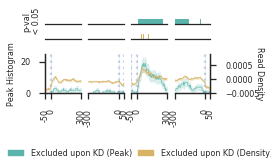

In [15]:
density_excl.color = '#d8b365'
peak_excl.color = '#5ab4ac'

mag = 1
fig = plt.figure(figsize=(4*mag, 1.5*mag))
full_grid = gridspec.GridSpec(6, 4, height_ratios=[1, 1, 1, 1, 2, 8], )

excl_read_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[3, 1:4])
excl_peak_heatmap_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[1, 1:4])
spacer_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[4, 1:4])

map_row = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=full_grid[5, 1:4])

read_map_regions = []
peak_map_regions = []

excl_read_heatmap_regions = []
excl_peak_heatmap_regions = []

for i in range(4):
    peak_map_regions.append(plt.subplot(map_row[i:i+1]))
    read_map_regions.append(peak_map_regions[i].twinx())
    excl_read_heatmap_regions.append(plt.subplot(excl_read_heatmap_row[i:i+1]))
    excl_peak_heatmap_regions.append(plt.subplot(excl_peak_heatmap_row[i:i+1]))

density_plotter = Plotter._SEPlotter(lines=[density_excl], num_regions=4)
read_map_regions = density_plotter.plot(read_map_regions, None)

read_plotter = Plotter._SEPlotter(lines=[peak_excl], num_regions=4)
peak_map_regions = read_plotter.plot(peak_map_regions, None)
# RDPlotter.plot_se([density_incl, density_excl], read_map_regions, density_colors) # density_bg
# peak_map_regions = Plotter.plot_se([peak_incl, peak_excl], 'tmp.out') # peak_bg

excl_peak_heatmap_regions[0].set_ylabel('p-val\n < 0.05', size=FONTSIZE)

read_map_regions[3].set_ylabel("Read Density", rotation=270, size=FONTSIZE)
read_map_regions[3].yaxis.set_visible(True)
read_map_regions[0].yaxis.set_visible(False)

peak_map_regions[3].yaxis.set_visible(False)
peak_map_regions[0].yaxis.set_visible(True)
peak_map_regions[0].set_ylabel("Peak Histogram", size=FONTSIZE)
peak_map_regions[0].yaxis.tick_right()

read_ymin = -0.0005
read_ymax = 0.0009
peak_ymin = 0
peak_ymax = 25

for ax in read_map_regions:
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_ylim(read_ymin, read_ymax)
    
for ax in peak_map_regions:
    ax.tick_params(labelsize=FONTSIZE)
    ax.set_ylim(peak_ymin, peak_ymax)

read_map_regions[0].yaxis.set_ticks([read_ymin, read_ymax])
read_map_regions[0].yaxis.set_ticklabels([read_ymin*10000, read_ymax*10000])
peak_map_regions[3].yaxis.set_ticks([peak_ymin, peak_ymax])
peak_map_regions[3].yaxis.set_ticklabels([peak_ymin, peak_ymax])

sns.despine(ax=read_map_regions[0], top=True, left=False, right=True)
sns.despine(ax=peak_map_regions[3], top=True, left=True, right=False)

# create lists of things to make parsing easier
pvalue_files = [excl_peak_pvalue, excl_read_pvalue]

heatmap_regions = [
    excl_peak_heatmap_regions,
    excl_read_heatmap_regions
]

# need to create cmaps based on each peak/read color
read_excl_cmap = matplotlib.colors.ListedColormap(['white', density_excl.color], name='from_list', N=None)
peak_excl_cmap = matplotlib.colors.ListedColormap(['white', peak_excl.color], name='from_list', N=None)

# despine stuff
for region in read_map_regions[1:3]:
    sns.despine(ax=region, top=True, left=True, right=True, bottom=False)
for region in peak_map_regions[1:3]:
    sns.despine(ax=region, top=True, left=True, right=True, bottom=False)
sns.despine(ax=peak_map_regions[0], top=True, left=False, right=True, bottom=False)
sns.despine(ax=read_map_regions[0], top=True, left=False, right=True, bottom=False)
sns.despine(ax=read_map_regions[3], top=True, left=True, right=False, bottom=False)
sns.despine(ax=peak_map_regions[3], top=True, left=True, right=False, bottom=False)


    
    
colors = [
    peak_excl_cmap, read_excl_cmap
]

# plot the heatmaps
for i in range(0, len(pvalue_files)):
    lst = []
    lst = open(pvalue_files[i], 'r').readlines()
    lst = [float(l.rstrip().split('\t')[1]) for l in lst]
    # if i >= 2: # the read density pvalues are just pvalues, so let's plot the -log10 (fix later)
    #     lst = [p for p in lst] # [-np.log10(p) for p in lst]
    # hide anything that isn't significant.
    lst = [mask(l) for l in lst]
    # 
    remove_lines = True if i !=3 else False
    
    plot_heatmap(lst, heatmap_regions[i], colors[i], remove_lines=False)
    

excl_peak_patch = mpatches.Patch(color=peak_excl.color, label='Excluded upon KD (Peak)')
excl_density_patch = mpatches.Patch(color=density_excl.color, label='Excluded upon KD (Density)')

leg = read_map_regions[0].legend(
    bbox_to_anchor=(2.5, -1.3), loc=1, mode="expand",
    handles=[excl_density_patch, excl_peak_patch],
    borderaxespad=0., ncol=2, fontsize=FONTSIZE
)

peak_map_regions[0].axvline(50, alpha=0.3, linestyle=':')
peak_map_regions[1].axvline(300, alpha=0.3, linestyle=':')
peak_map_regions[1].axvline(350, alpha=0.3, linestyle=':')
peak_map_regions[2].axvline(0, alpha=0.3, linestyle=':')
peak_map_regions[2].axvline(50, alpha=0.3, linestyle=':')
peak_map_regions[3].axvline(300, alpha=0.3, linestyle=':')

output_file = '/home/bay001/projects/gabe_qc_20170612/analysis/204_01_RBFOX2_peak_vs_density_with_pvalue_heatmaps_as_hist.excl_on_kd.svg'
fig.savefig(output_file)